Simulation of Fire Spreading in a Forest using Von Neumann Neighbourhood and Moore Neighbourhood Algorithms
(Evaluating Sequential and Parallel Implementations)

By Oluwatosin Olubiyi

Initialization of the Forest Grids and General Properties

In [1]:
## assumptions and definitions

EMPTY = 0 # 0 - empty area or cell
TREE = 1 # 1 - cell or area with non burning tree
BTREE = 2 # 2 - cell or area with burning tree\
BORDER = 3 # 3 - border of the forest

probTree = 0.8 # probability of a tree
probBurning = 0.01 # probability of a tree burning
probImmune = 0.3 # probability of a tree to be immune to fire
probLightning = 0.001 # probability of lightning strike

In [2]:
# initializie time at start of simulation

# importing all required libraries

import time
import numpy as np
import matplotlib.pyplot as plt
from random import *
import math
from matplotlib import animation
from copy import deepcopy
import multiprocessing as mp
import numba

initTime = time.perf_counter()
time.sleep(3)
endTime = time.perf_counter()

# difference in time
print("Time Started: {0}, Time Ended: {1}. \nTime Elapsed during the iteration: {2} seconds".format(initTime, endTime, endTime - initTime))

Time Started: 8.4606246, Time Ended: 11.4705223. 
Time Elapsed during the iteration: 3.0098977000000016 seconds


Sequential Implementation

In [3]:

# Initialize the forest with non burning trees, empty cells, burning trees and border cells
# - initializing the discrete stochastic system with probTree & probBurning.

def forest_initializer(forest_size):
    
    print("Initializing the forest...")
    
    # initialize the forest with border cells
    forest = BORDER * np.ones((forest_size + 2, forest_size + 2)) 
    
    for i in range(1,forest_size):
        for j in range(1,forest_size):
            if random() < probBurning:
                forest[i][j] = BTREE # there is a burning tree in the cell
            elif random() < probTree:
                forest[i][j] = TREE # there is a non burning tree in the cell
            else:
                forest[i][j] = EMPTY
        
    print("Initialization completed. \n")
    
    return forest

In [4]:
# spreading the fire using the von Neumann neighborhood algorithm

def vnn_fire_spreader(forest, forest_size):
    
    print("Spreading the fire...")
    
    # spreading the fire using von Neumann neighborhood
    for i in range(1, forest_size + 1):
        for j in range(1, forest_size + 1):
            if forest[i][j] == TREE: # if the cell is a tree
                if random() < probImmune: # if the tree is immune to fire
                    forest[i][j] = TREE
                else: # if the tree is not immune to fire
                    if (forest[i - 1][j] == BTREE or forest[i + 1][j] == BTREE or 
                        forest[i][j - 1] == BTREE or forest[i][j + 1] == BTREE): # if the tree is next to a burning tree
                        forest[i - 1][j] = BTREE # the tree burns
                    elif random() < probLightning: # if lightning strikes the site
                        forest[i][j] = BTREE # the tree burns
                    else:
                        forest[i][j] = TREE # the tree is not burned
            elif forest[i][j] == BTREE: # if the cell is a burning tree, then it burns down
                forest[i][j] = EMPTY
            else:  # otherwise the cell is an empty cell
                forest[i][j] = EMPTY # the cell remains empty
                
    print("Spreading completed. \n")
    
    return forest

In [5]:
# spreading the fire using the Moore neighborhood algorithm

def m_fire_spreader(forest, forest_size):
    
    print("Spreading the fire using the Moore neighborhood...")
    
    # spreading the fire using Moore neighborhood
    for i in range(1, forest_size + 1):
        for j in range(1, forest_size + 1):
            if forest[i][j] == TREE: # if the cell is a tree
                if random() < probImmune: # if the tree is immune to fire
                    forest[i][j] = TREE
                else: # if the tree is not immune to fire
                    if (forest[i - 1][j] == BTREE or forest[i + 1][j] == BTREE or 
                        forest[i][j - 1] == BTREE or forest[i][j + 1] == BTREE or 
                        forest[i - 1][j - 1] == BTREE or forest[i - 1][j + 1] == BTREE or 
                        forest[i + 1][j - 1] == BTREE or forest[i + 1][j + 1] == BTREE): # if the tree is next to a burning tree
                        forest[i - 1][j] = BTREE # the tree burns
                    elif random() < probLightning: # if lightning strikes the site
                        forest[i][j] = BTREE # the tree burns
                    else:
                        forest[i][j] = TREE # the tree is not burned
            elif forest[i][j] == BTREE: # if the cell is a burning tree, then it burns down
                forest[i][j] = EMPTY
            else:  # otherwise the cell is an empty cell
                forest[i][j] = EMPTY # the cell remains empty
                
    print("Spreading completed. \n")
    
    return forest

Parallel Computing Implementation

In [6]:
# Initialize the forest with non burning trees, empty cells, burning trees and border cells
# - initializing the discrete stochastic system with probTree & probBurning.

@numba.jit(nopython=True)
def parallel_forest_initializer(forest_size):
    
    print("Initializing the forest...")
    
    # initialize the forest with border cells
    forest = BORDER * np.ones((forest_size + 2, forest_size + 2)) 
    
    for i in numba.prange(1, forest_size + 1):
        for j in numba.prange(1, forest_size + 1):
            if random() < probBurning:
                forest[i][j] = BTREE # there is a burning tree in the cell
            elif random() < probTree:
                forest[i][j] = TREE # there is a non burning tree in the cell
            else:
                forest[i][j] = EMPTY
    
    print("Initialization completed. \n")
    
    return forest

In [7]:
# spreading the fire using the von Neumann neighborhood algorithm

@numba.jit(nopython=True)
def parallel_vnn_fire_spreader(forest, forest_size):
    
    print("Spreading the fire...")
    
    # spreading the fire using von Neumann neighborhood
    for i in numba.prange(1, forest_size + 1):
        for j in numba.prange(1, forest_size + 1):
            if forest[i][j] == TREE: # if the cell is a tree
                if random() < probImmune: # if the tree is immune to fire
                    forest[i][j] = TREE
                else: # if the tree is not immune to fire
                    if (forest[i - 1][j] == BTREE or forest[i + 1][j] == BTREE or 
                        forest[i][j - 1] == BTREE or forest[i][j + 1] == BTREE): # if the tree is next to a burning tree
                        forest[i - 1][j] = BTREE # the tree burns
                    elif random() < probLightning: # if lightning strikes the site
                        forest[i][j] = BTREE # the tree burns
                    else:
                        forest[i][j] = TREE # the tree is not burned
            elif forest[i][j] == BTREE: # if the cell is a burning tree, then it burns down
                forest[i][j] = EMPTY
            else:  # otherwise the cell is an empty cell
                forest[i][j] = EMPTY # the cell remains empty
                
    print("Spreading completed. \n")
    
    return forest

In [8]:
# spreading the fire using the Moore neighborhood algorithm

@numba.jit(nopython=True)
def parallel_m_fire_spreader(forest, forest_size):
    
    print("Spreading the fire using the Moore neighborhood...")
    
    # spreading the fire using Moore neighborhood
    for i in numba.prange(1, forest_size + 1):
        for j in numba.prange(1, forest_size + 1):
            if forest[i][j] == TREE: # if the cell is a tree
                if random() < probImmune: # if the tree is immune to fire
                    forest[i][j] = TREE
                else: # if the tree is not immune to fire
                    if (forest[i - 1][j] == BTREE or forest[i + 1][j] == BTREE or 
                        forest[i][j - 1] == BTREE or forest[i][j + 1] == BTREE or 
                        forest[i - 1][j - 1] == BTREE or forest[i - 1][j + 1] == BTREE or 
                        forest[i + 1][j - 1] == BTREE or forest[i + 1][j + 1] == BTREE): # if the tree is next to a burning tree
                        forest[i - 1][j] = BTREE # the tree burns
                    elif random() < probLightning: # if lightning strikes the site
                        forest[i][j] = BTREE # the tree burns
                    else:
                        forest[i][j] = TREE # the tree is not burned
            elif forest[i][j] == BTREE: # if the cell is a burning tree, then it burns down
                forest[i][j] = EMPTY
            else:  # otherwise the cell is an empty cell
                forest[i][j] = EMPTY # the cell remains empty
                
    print("Spreading completed. \n")
    
    return forest

Visualization and Animation of the Fire Spread in the Forest

In [9]:
%matplotlib notebook

In [13]:
# animate the fire spreading with animation

def visualize_forest(forest_size, spread_count):
    
    print("Setting up visualization.....")
    
    forestGridImages = []
    
    # initialize the plot for the forest
    ax = plt.axes(xlim=(0, forest_size + 2), ylim=(0, forest_size + 2))
    ax.set_aspect('equal')
    ax.set_title('Fire Spread for forest Grid size {0} at {1} iterations'.format(forest_size, spread_count))
    ax.grid(True)    
    plt.ion()
    
    # generate the forest grid
    forestGrid, timeUsed = forest_initializer(forest_size)
    
    # spread the fire for spread_count times
    for count in range(spread_count):
        
        for i in range(forest_size + 2):
            for j in range(forest_size + 2):
                if forestGrid[i][j] == TREE:                
                    ax.add_patch(plt.Rectangle((i, j), 1, 1, color='green'))
                elif forestGrid[i][j] == BTREE:
                    ax.add_patch(plt.Rectangle((i, j), 1, 1, color='red'))
                elif forestGrid[i][j] == EMPTY:
                    ax.add_patch(plt.Rectangle((i, j), 1, 1, color='white'))
                else:
                    ax.add_patch(plt.Rectangle((i, j), 1, 1, color='black'))    
                    
        # update the forest grid image
        forestGridImages.append(ax.imshow(forestGrid))
        
        # we will use the moore neighborhood algorithm for spreading the fire
        forestGrid = m_fire_spreader(forestGrid, forest_size)
        
        print('Iteration: {0} completed'.format(count+1)
    
    print('Visualization (Sequential) completed for forest grid size {0}'.format(forest_size))
              
    return forestGridImages

In [11]:
# animate the fire spreading with animation

@numba.jit(nopython=True)
def parallel_visualize_forest(forest_size, spread_count):
    
    print("Setting up visualization.....")
    
    forestGridImages = []
    
    # initialize the plot for the forest
    ax = plt.axes(xlim=(0, forest_size + 2), ylim=(0, forest_size + 2))
    ax.set_aspect('equal')
    ax.set_title('Fire Spread for forest Grid size {0} at {1} iterations'.format(forest_size, spread_count))
    ax.grid(True)    
    plt.ion()
    
    # generate the forest grid
    forestGrid = parallel_forest_initializer(forest_size)
    
    # spread the fire for spread_count times
    for count in numba.prange(spread_count):
        
        for i in numba.prange(forest_size + 2):
            for j in numba.prange(forest_size + 2):
                if forestGrid[i][j] == TREE:                
                    ax.add_patch(plt.Rectangle((i, j), 1, 1, color='green'))
                elif forestGrid[i][j] == BTREE:
                    ax.add_patch(plt.Rectangle((i, j), 1, 1, color='red'))
                elif forestGrid[i][j] == EMPTY:
                    ax.add_patch(plt.Rectangle((i, j), 1, 1, color='white'))
                else:
                    ax.add_patch(plt.Rectangle((i, j), 1, 1, color='black'))    
                    
        # update the forest grid image
        forestGridImages.append(ax.imshow(forestGrid))
        
        # we will use the moore neighborhood algorithm for spreading the fire
        forestGrid = parallel_m_fire_spreader(forestGrid, forest_size)
        
        print('Iteration: {0} completed'.format(count+1))        
    
    
    print('Visualization (Parallel) completed for forest grid size {0}'.format(forest_size))
    
    return forestGridImages

<IPython.core.display.Javascript object>


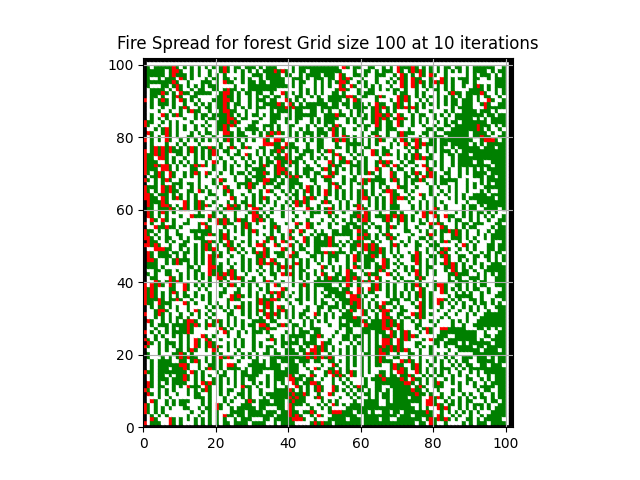

Initializing the forest...
Initialization completed. 
Time Elapsed during the initialization: 0.005119699999998062 seconds
Spreading the fire using the Moore neighborhood...
Spreading completed. 
Time Elapsed during the spreading: 0.02795120000000395 seconds
Iteration: 1, Time elapsed so far: 5.0162285 seconds
Spreading the fire using the Moore neighborhood...
Spreading completed. 
Time Elapsed during the spreading: 0.027253600000001654 seconds
Iteration: 2, Time elapsed so far: 9.900115799999998 seconds
Spreading the fire using the Moore neighborhood...
Spreading completed. 
Time Elapsed during the spreading: 0.027880299999999636 seconds
Iteration: 3, Time elapsed so far: 15.2465583 seconds
Spreading the fire using the Moore neighborhood...
Spreading completed. 
Time Elapsed during the spreading: 0.027621699999997418 seconds
Iteration: 4, Time elapsed so far: 20.9198294 seconds
Spreading the fire using the Moore neighborhood...
Spreading completed. 
Time Elapsed during the spreading: 

c:\program files (x86)\python39-32\lib\site-packages\matplotlib\animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


In [12]:
# time at start of visualization
initTime100 = time.perf_counter()

fig100 = plt.figure(1)

forestGridImages100 = visualize_forest(100, 10)
print('Visualization (Sequential) completed in {0} seconds'.format(time.perf_counter() - initTime100))

# display the forest fire images
anim100 = animation.ArtistAnimation(fig100, forestGridImages100, interval=5, blit=True, repeat_delay=500)
#anim.save('forest_fire_moore_neighborhood.gif')

plt.show()

In [ ]:
# time at start of visualization
initTime400 = time.perf_counter()

fig400 = plt.figure(2)

forestGridImages400 = visualize_forest(400, 10)
print('Visualization (Sequential) completed in {0} seconds'.format(time.perf_counter() - initTime400))

# display the forest fire images
anim400 = animation.ArtistAnimation(fig400, forestGridImages400, interval=5, blit=True, repeat_delay=500)

plt.show()

<IPython.core.display.Javascript object>

Initializing the forest...
Initialization completed. 
Time Elapsed during the initialization: 0.07711150000000089 seconds
Spreading the fire using the Moore neighborhood...
Spreading completed. 
Time Elapsed during the spreading: 0.4916667999999902 seconds
Iteration: 1, Time elapsed so far: 82.3198415 seconds


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



In [ ]:
# time at start of visualization
initTime800 = time.perf_counter()

fig800 = plt.figure(3)

forestGridImages800 = visualize_forest(800, 10)
print('Visualization (Sequential) completed in {0} seconds'.format(time.perf_counter() - initTime800))

# display the forest fire images
anim800 = animation.ArtistAnimation(fig800, forestGridImages800, interval=5, blit=True, repeat_delay=500)

plt.show()

In [ ]:
# time at start of visualization
initTime1000 = time.perf_counter()

fig1000 = plt.figure(4)

forestGridImages1000 = visualize_forest(1000, 10)
print('Visualization (Sequential) completed in {0} seconds'.format(time.perf_counter() - initTime1000))

# display the forest fire images
anim1000 = animation.ArtistAnimation(fig1000, forestGridImages1000, interval=5, blit=True, repeat_delay=500)

plt.show()

In [ ]:
# time at start of visualization
initTime1200 = time.perf_counter()

fig1200 = plt.figure(5)

forestGridImages1200 = visualize_forest(1200, 10)
print('Visualization (Sequential) completed in {0} seconds'.format(time.perf_counter() - initTime1200))

# display the forest fire images
anim1200 = animation.ArtistAnimation(fig1200, forestGridImages1200, interval=5, blit=True, repeat_delay=500)

plt.show()

In [ ]:
# time at start of visualization
initTime2000 = time.perf_counter()

fig2000 = plt.figure(6)

forestGridImages1000 = visualize_forest(2000, 10)
print('Visualization (Sequential) completed in {0} seconds'.format(time.perf_counter() - initTime2000))

# display the forest fire images
anim2000 = animation.ArtistAnimation(fig2000, forestGridImages2000, interval=5, blit=True, repeat_delay=500)

plt.show()

In [ ]:
# time at start of visualization
initTime100p = time.perf_counter()

fig100p = plt.figure(7)

forestGridImages100p = parallel_visualize_forest(100, 10)
print('Visualization (Parallel) completed in {0} seconds'.format(time.perf_counter() - initTime100p))

# display the forest fire images
anim100p = animation.ArtistAnimation(fig100p, forestGridImages100p, interval=5, blit=True, repeat_delay=500)

plt.show()

<IPython.core.display.Javascript object>

Iteration: 1 completed
Iteration: 2 completed
Iteration: 3 completed


In [ ]:
# time at start of visualization
initTime400p = time.perf_counter()

fig400p = plt.figure(8)

forestGridImages400p = parallel_visualize_forest(400, 10)
print('Visualization (Parallel) completed in {0} seconds'.format(time.perf_counter() - initTime400p))

# display the forest fire images
anim400p = animation.ArtistAnimation(fig400p, forestGridImages400p, interval=5, blit=True, repeat_delay=500)

plt.show()

In [ ]:
# time at start of visualization
initTime800p = time.perf_counter()

fig800p = plt.figure(9)

forestGridImages800p = parallel_visualize_forest(800, 10)
print('Visualization (Parallel) completed in {0} seconds'.format(time.perf_counter() - initTime800p))

# display the forest fire images
anim800p = animation.ArtistAnimation(fig800p, forestGridImages800p, interval=5, blit=True, repeat_delay=500)

plt.show()

In [ ]:
# time at start of visualization
initTime1200p = time.perf_counter()

fig1200p = plt.figure(11)

forestGridImages1200p = parallel_visualize_forest(1200, 10)
print('Visualization (Parallel) completed in {0} seconds'.format(time.perf_counter() - initTime1200p))

# display the forest fire images
anim1200p = animation.ArtistAnimation(fig1200p, forestGridImages1200p, interval=5, blit=True, repeat_delay=500)

plt.show()

In [ ]:
# time at start of visualization
initTime2000p = time.perf_counter()

fig2000p = plt.figure(12)

forestGridImages2000p = parallel_visualize_forest(2000, 10)
print('Visualization (Parallel) completed in {0} seconds'.format(time.perf_counter() - initTime2000p))

# display the forest fire images
anim2000p = animation.ArtistAnimation(fig2000p, forestGridImages2000p, interval=5, blit=True, repeat_delay=500)

plt.show()

In [ ]:
# time at start of visualization
initTime1000p = time.perf_counter()

fig1000p = plt.figure(10)

forestGridImages1000p = parallel_visualize_forest(1000, 10)
print('Visualization (Parallel) completed in {0} seconds'.format(time.perf_counter() - initTime1000p))

# display the forest fire images
anim1000p = animation.ArtistAnimation(fig1000p, forestGridImages1000p, interval=5, blit=True, repeat_delay=500)

plt.show()

In [ ]:
initTime = time.perf_counter()

# generate the random NumPy array to Row Normalise.
list_a = randomArray(rows=3000, columns=3000)
# number of processors
CPUs = mp.cpu_count()
pool = mp.Pool(CPUs)
results = [pool.apply(rowNormalisation, args=(row,)) for row in list_a]
pool.close()

endTime = time.perf_counter()

print("Array normalized in {0} seconds", endTime - initTime)